In [ ]:
import keras
import os
import cv2
import cv2 as cv
import os
import numpy as np
import pandas as pd
import skimage
#import tensorflow as tf
from keras import backend as K
import random
import skimage
from skimage.transform import rescale
keras.__version__

'2.3.1'

In [ ]:
import numpy as np
import sys
import io
import base64
import cv2

import skimage

import os

import pandas as pd


from os import listdir
from os.path import isfile, join
from shutil import copy
%tensorflow_version 1.x
import tensorflow as tf
import sys
import time
from keras.preprocessing import sequence
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
file_name = '/content/drive/My Drive/MP/Datasets/MSVD.csv'
feature_path = '/content/drive/My Drive/MP/Datasets/NasNetLargeFeatures'
seed = 0

In [ ]:
def get_english_data(file_name, feature_path):
  
  data = pd.read_csv(file_name)
  data = data[data['Language'] == 'English']
  data = data.drop_duplicates(subset=['VideoID' , 'Start' , 'End'])
  
  # the result contains start and end values of the csv file.
  feature_files = [f[:f.find('.')] for f in listdir(feature_path) if isfile(join(feature_path, f))]
  #print('count=',len(feature_files))
  #features_files_df = pd.DataFrame(np.array([feature_files]), columns=['file_names'])
  
  data['concatenated_file_name'] = data.apply(lambda row: row['VideoID'] + 
                                   ( '_' + str(int(row['Start'])) if int(row['Start']) != -1 else '') +
                                   ( '_' + str(int(row['End'])) if int(row['End']) != -1 else ''), axis=1)
  
  #result = data.set_index('concatenated_file_name').join(features_files_df.set_index('file_names'))
  
  result = data[data['concatenated_file_name'].isin(feature_files)]
  
  return result

In [ ]:
data = get_english_data(file_name, feature_path)

In [ ]:
data.count()

VideoID                   1970
Start                     1970
End                       1970
WorkerID                  1970
Source                    1970
AnnotationTime            1970
Language                  1970
Description               1970
concatenated_file_name    1970
dtype: int64

In [ ]:
data.head()

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description,concatenated_file_name
18,mv89psg6zh4,33,46,682611,clean,66,English,A bird in a sink keeps getting under the runni...,mv89psg6zh4_33_46
56,ZbzDGXEwtGc,6,15,550906,clean,24,English,a plane flying in the sky,ZbzDGXEwtGc_6_15
125,jbzaMtPYtl8,48,58,682611,clean,203,English,Two men are rolling huge tires sideways down a...,jbzaMtPYtl8_48_58
176,g36ho6UrBz0,5,20,550906,clean,28,English,a man playing a guitar outside his house,g36ho6UrBz0_5_20
251,04Gt01vatkk,248,265,550906,clean,33,English,A woman cuts an oion.,04Gt01vatkk_248_265


In [ ]:
def copyFile(row, src, dest):
  try :
    copy(src +'/' +row['concatenated_file_name'] + '.npy', dest)
  except :
    print("File : " + row['concatenated_file_name'] + " not found")

In [ ]:
def get_random_mask(train_size, english_data):
  np.random.seed(seed)
  return np.random.choice([0, 1], size=(len(english_data),), p=[train_size, 1-train_size]) < 1  

In [ ]:
def split_english_data(videos_path, train_path, test_path, english_data, train_size):
  
  # get mask.
  msk = get_random_mask(train_size, english_data)
  
  # split data.
  train = english_data[msk]
  test = english_data[~msk]
  
  # copy data to specific files.
  train.apply(lambda row: copyFile(row, videos_path, train_path), axis=1)
  test.apply(lambda row: copyFile(row, videos_path, test_path), axis=1)
  return [train, test]

In [ ]:
!mkdir train
!mkdir test

In [ ]:
split_english_data(feature_path,'/content/train','/content/test',data,0.8)

File : -rvjK0lE3z4_33_43 not found
File : msCidKHOh74_410_418 not found
File : Lt1JijkvSKk_0_10 not found
File : IhwPQL9dFYc_61_75 not found


In [ ]:
train_file_names = os.listdir('/content/drive/My Drive/major_project/train')
test_file_names = os.listdir('/content/drive/My Drive/major_project/test')
rgb_file_names = os.listdir(feature_path)

print("train-size : ", len(train_file_names))
print("test-size : ", len(test_file_names))
print("rgb-feats-size : ", len(rgb_file_names))

for f in train_file_names:
  if f in test_file_names:
    print(f)

In [ ]:
# copy train test split tot drive to prevent running code after every reset
!rm -r '/content/drive/My Drive/MP/train'
!rm -r '/content/drive/My Drive/MP/test'
!cp -r '/content/train' '/content/drive/My Drive/MP'
!cp -r '/content/test' '/content/drive/My Drive/MP'

rm: cannot remove '/content/drive/My Drive/MP/train': No such file or directory
rm: cannot remove '/content/drive/My Drive/MP/test': No such file or directory


## MODEL

In [ ]:
!mkdir '/content/drive/My Drive/MP/Sequence 2 Vector'
!mkdir '/content/drive/My Drive/MP/Sequence 2 Vector/models'
!mkdir '/content/drive/My Drive/MP/Sequence 2 Vector/data'
!mkdir '/content/drive/My Drive/MP/Sequence 2 Vector/data/wordtoix'
!mkdir '/content/drive/My Drive/MP/Sequence 2 Vector/data/ixtoword'
!mkdir '/content/drive/My Drive/MP/Sequence 2 Vector/data/bias_init_vector'
!mkdir '/content/drive/My Drive/MP/Sequence 2 Vector/loss_imgs'

In [ ]:
#=====================================================================================
# Global Parameters
#=====================================================================================
video_train_feat_path = '/content/drive/My Drive/MP/train'
video_test_feat_path = '/content/drive/My Drive/MP/test'

video_train_data_path = '/content/drive/My Drive/MP/Datasets/MSVD.csv'
video_test_data_path = '/content/drive/My Drive/MP/Datasets/MSVD.csv'

#!mkdir '/content/drive/My Drive/MP/Sequence 2 Vector/models/nasnet(RMSProp)'
model_path = '/content/drive/My Drive/MP/Sequence 2 Vector/models/glove+blstm'

#==================================/=====================================================
# Train Parameters
#=======================================================================================
dim_image = 4032
dim_hidden = 512

n_video_lstm_step = 80
n_caption_lstm_step = 20
n_frame_step = 80

n_epochs = 1000
batch_size = 128
learning_rate = 0.001

dim_query_attention = 80

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, hidden_size)
    score = self.V(tf.nn.tanh(
        self.W1(values) * self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


class Video_Caption_Generator():
    def __init__(self, dim_image, n_words, dim_hidden, batch_size, n_lstm_steps, n_video_lstm_step, n_caption_lstm_step, Wemb, bias_init_vector=None):
        self.dim_image = dim_image
        self.n_words = n_words
        self.dim_hidden = dim_hidden
        self.batch_size = batch_size
        self.n_lstm_steps = n_lstm_steps
        self.n_video_lstm_step = n_video_lstm_step
        self.n_caption_lstm_step = n_caption_lstm_step

        self.Wemb = tf.convert_to_tensor(Wemb, dtype=tf.float32)
            #self.bemb = tf.Variable(tf.zeros([dim_hidden]), name='bemb')

        self.lstm1 = tf.nn.rnn_cell.LSTMCell(dim_hidden, state_is_tuple=False)
        self.lstm1 = tf.nn.rnn_cell.DropoutWrapper(self.lstm1, output_keep_prob=0.6)
        
        self.attentions = []
        for i in range(n_caption_lstm_step):
          self.attentions.append(BahdanauAttention(dim_query_attention))
        
        self.lstm2 = tf.nn.rnn_cell.LSTMCell(dim_hidden, state_is_tuple=False)
        self.lstm2 = tf.nn.rnn_cell.DropoutWrapper(self.lstm2, output_keep_prob=0.6)
        
        self.lstm3 = tf.nn.rnn_cell.LSTMCell(dim_hidden, state_is_tuple=False)
        self.lstm3 = tf.nn.rnn_cell.DropoutWrapper(self.lstm3, output_keep_prob=0.6)

        self.encode_image_W = tf.Variable( tf.random_uniform([dim_image, dim_hidden], -0.1, 0.1), name='encode_image_W')
        self.encode_image_b = tf.Variable( tf.zeros([dim_hidden]), name='encode_image_b')

        self.embed_word_W = tf.Variable(tf.random_uniform([dim_hidden, n_words], -0.1,0.1), name='embed_word_W')
        if bias_init_vector is not None:
            self.embed_word_b = tf.Variable(bias_init_vector.astype(np.float32), name='embed_word_b')
        else:
            self.embed_word_b = tf.Variable(tf.zeros([n_words]), name='embed_word_b')

    def build_model(self):
        #Wemb = tf.placeholder(tf.float32, [self.n_words, 104])
      
        video = tf.placeholder(tf.float32, [self.batch_size, self.n_video_lstm_step, self.dim_image])
        video_mask = tf.placeholder(tf.float32, [self.batch_size, self.n_video_lstm_step])

        caption = tf.placeholder(tf.int32, [self.batch_size, self.n_caption_lstm_step+1])
        caption_mask = tf.placeholder(tf.float32, [self.batch_size, self.n_caption_lstm_step+1])

        video_flat = tf.reshape(video, [-1, self.dim_image])
        image_emb = tf.nn.xw_plus_b( video_flat, self.encode_image_W, self.encode_image_b ) # (batch_size*n_lstm_steps, dim_hidden)
        image_emb = tf.reshape(image_emb, [self.batch_size, self.n_lstm_steps, self.dim_hidden])

        state1 = tf.zeros([self.batch_size, self.lstm1.state_size])
        state2 = tf.zeros([self.batch_size, self.lstm2.state_size])
        state3 = tf.zeros([self.batch_size, self.lstm3.state_size])
        
        padding = tf.zeros([self.batch_size, self.dim_hidden])

        probs = []
        loss = 0.0
        
        out_list = []
        output1_full=[]
        output2_full=[]

        ##############################  Encoding Stage ##################################
        with tf.variable_scope("Encoding") as scope:  
          for i in range(0, self.n_video_lstm_step):
              if i > 0:
                  scope.reuse_variables()

              with tf.variable_scope("LSTM1"):
                  output1, state1 = self.lstm1(image_emb[:,i,:], state1)

              with tf.variable_scope("LSTM2"):
                  output2, state2 = self.lstm2(image_emb[:,self.n_video_lstm_step-i-1,:], state2)

              output1_full.append(output1)
              output2_full.append(output2)

          for i in range(0, self.n_video_lstm_step):
              out_list.append(tf.concat([output1_full[i], output2_full[self.n_video_lstm_step-i-1]], 1))
              
        #########################  Attention ############################################
        out_list = tf.convert_to_tensor(out_list)
        out_list = tf.transpose(out_list, perm=[1, 0, 2])

        ############################# Decoding Stage ######################################
        with tf.variable_scope("Decoding") as scope:  
          
          for i in range(0, self.n_caption_lstm_step): ## Phase 2 => only generate captions
              #if i == 0:
              #    current_embed = tf.zeros([self.batch_size, self.dim_hidden])
              #else:
              
#               if i != 0:
#                 padding = tf.zeros([self.batch_size, self.dim_hidden])
                
              if i > 0:
                  scope.reuse_variables()
              
              current_embed = tf.nn.embedding_lookup(self.Wemb, caption[:, i])

              with tf.variable_scope("LSTM3"):
                  output3, state3 = self.lstm3(tf.concat([current_embed, self.attentions[i](state3, out_list)[0]],1) , state3)

              labels = tf.expand_dims(caption[:, i+1], 1)
              indices = tf.expand_dims(tf.range(0, self.batch_size, 1), 1)
              concated = tf.concat([indices, labels],1)
              onehot_labels = tf.sparse_to_dense(concated, tf.stack([self.batch_size, self.n_words]), 1.0, 0.0)
              


              logit_words = tf.nn.xw_plus_b(output3, self.embed_word_W, self.embed_word_b)
              cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit_words, labels=onehot_labels)
              cross_entropy = cross_entropy * caption_mask[:,i]
              probs.append(logit_words)

              ####################### New Code #################

              mean_squared_error = tf.losses.mean_squared_error( labels=onehot_labels , predictions=logit_words )

              ##################################################

              current_loss = 0.9*(tf.reduce_sum(cross_entropy)/self.batch_size) + 0.1*(mean_squared_error/self.batch_size)
              loss = loss + current_loss

        return loss, video, video_mask, caption, caption_mask, probs


    def build_generator(self):
        video = tf.placeholder(tf.float32, [1, self.n_video_lstm_step, self.dim_image])
        video_mask = tf.placeholder(tf.float32, [1, self.n_video_lstm_step])

        video_flat = tf.reshape(video, [-1, self.dim_image])
        image_emb = tf.nn.xw_plus_b(video_flat, self.encode_image_W, self.encode_image_b)
        image_emb = tf.reshape(image_emb, [1, self.n_video_lstm_step, self.dim_hidden])

        state1 = tf.zeros([1, self.lstm1.state_size])
        state2 = tf.zeros([1, self.lstm2.state_size])
        state3 = tf.zeros([1, self.lstm3.state_size])
        padding = tf.zeros([1, self.dim_hidden])

        generated_words = []

        probs = []
        embeds = []
        

        ##############################  Encoding Stage ##################################
        
        out_list = []
        output1_full=[]
        output2_full=[]
        
        with tf.variable_scope("Encoding") as scope:  
          for i in range(0, self.n_video_lstm_step):
              if i > 0:
                  scope.reuse_variables()

              with tf.variable_scope("LSTM1"):
                  output1, state1 = self.lstm1(image_emb[:, i, :], state1)

              with tf.variable_scope("LSTM2"):
                  output2, state2 = self.lstm2(image_emb[:,self.n_video_lstm_step-i-1,:], state2)

              output1_full.append(output1)
              output2_full.append(output2)

          for i in range(0, self.n_video_lstm_step):
              out_list.append(tf.concat([output1_full[i], output2_full[self.n_video_lstm_step-i-1]], 1))
       
        #########################  Attention ############################################
          out_list = tf.convert_to_tensor(out_list)
          out_list = tf.transpose(out_list, perm=[1, 0, 2])
        ##############################  Decoding Stage ##################################
        with tf.variable_scope("Decoding") as scope:  
          for i in range(0, self.n_caption_lstm_step):
              if i > 0:
                  scope.reuse_variables()

              if i == 0:
                  current_embed = tf.nn.embedding_lookup(self.Wemb, tf.ones([1], dtype=tf.int64))
              else:
                  padding = tf.zeros([1, self.dim_hidden])

              with tf.variable_scope("LSTM3"):
                  output3, state3 = self.lstm3(tf.concat([current_embed,self.attentions[i](state3, out_list)[0]],1), state3)

              logit_words = tf.nn.xw_plus_b( output3, self.embed_word_W, self.embed_word_b)
              max_prob_index = tf.argmax(logit_words, 1)[0]
              generated_words.append(max_prob_index)
              probs.append(logit_words)

              current_embed = tf.nn.embedding_lookup(self.Wemb, max_prob_index)
              current_embed = tf.expand_dims(current_embed, 0)

              embeds.append(current_embed)

        return video, video_mask, generated_words, probs, embeds

In [ ]:
def get_video_train_data(video_data_path, video_feat_path):
    video_data = pd.read_csv(video_data_path, sep=',')
    video_data = video_data[video_data['Language'] == 'English']
    video_data['video_path'] = video_data.apply(lambda row: row['VideoID'] + 
                                   ( '_' + str(int(row['Start'])) if int(row['Start']) != -1 else '') +
                                   ( '_' + str(int(row['End'])) if int(row['End']) != -1 else '') +'.npy', axis=1)
    video_data['video_path'] = video_data['video_path'].map(lambda x: os.path.join(video_feat_path, x))
    video_data = video_data[video_data['video_path'].map(lambda x: os.path.exists( x ))]
    video_data = video_data[video_data['Description'].map(lambda x: isinstance(x, str))]
    
    unique_filenames = sorted(video_data['video_path'].unique())
    train_data = video_data[video_data['video_path'].map(lambda x: x in unique_filenames)]
    
    return train_data

In [ ]:
def get_video_test_data(video_data_path, video_feat_path):
    video_data = pd.read_csv(video_data_path, sep=',')
    video_data = video_data[video_data['Language'] == 'English']
    video_data['video_path'] = video_data.apply(lambda row: row['VideoID'] + 
                                   ( '_' + str(int(row['Start'])) if int(row['Start']) != -1 else '') +
                                   ( '_' + str(int(row['End'])) if int(row['End']) != -1 else '')+'.npy', axis=1)
    video_data['video_path'] = video_data['video_path'].map(lambda x: os.path.join(video_feat_path, x))
    video_data = video_data[video_data['video_path'].map(lambda x: os.path.exists( x ))]
    video_data = video_data[video_data['Description'].map(lambda x: isinstance(x, str))]

    unique_filenames = sorted(video_data['video_path'].unique())
    test_data = video_data[video_data['video_path'].map(lambda x: x in unique_filenames)]

    return test_data

In [ ]:
train_csv = get_video_train_data(video_train_data_path , video_train_feat_path)
test_csv = get_video_test_data(video_test_data_path , video_test_feat_path)

# building word vocabulary with glove vectors

In [ ]:
def preProBuildWordVocab(sentence_iterator, word_count_threshold=3):
    # borrowed this function from NeuralTalk
    print ('preprocessing word counts and creating vocab based on word count threshold %d' % (word_count_threshold))
    word_counts = {}
    nsents = 0
    for sent in sentence_iterator:
        nsents += 1
        for w in sent.lower().split():
           word_counts[w] = word_counts.get(w, 0) + 1
    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    print ('filtered words from %d to %d' % (len(word_counts), len(vocab)))



    ixtoword = {}
    ixtoword[0] = '<pad>'
    ixtoword[1] = '<bos>'
    ixtoword[2] = '<eos>'
    ixtoword[3] = '<unk>'

    wordtoix = {}
    wordtoix['<pad>'] = 0
    wordtoix['<bos>'] = 1
    wordtoix['<eos>'] = 2
    wordtoix['<unk>'] = 3

    for idx, w in enumerate(vocab):
        wordtoix[w] = idx+4
        ixtoword[idx+4] = w

    embeddings_dict = {}
    with open("/content/drive/My Drive/MP/Sequence 2 Vector/data/glove.6B.100d.txt", 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector

    embeddings_dict['<pad>'] = np.append(np.zeros(100),np.array([0]))
    embeddings_dict['<bos>'] = np.append(np.zeros(100),np.array([0.5]))
    embeddings_dict['<eos>'] = np.append(np.zeros(100),np.array([1]))
    embeddings_dict['<unk>'] = np.append(np.zeros(100),np.array([-1]))
    new_vector_length = embeddings_dict['<unk>'].shape[0] # length of longest vector
    for key, word_vector in embeddings_dict.items():
        zero_append_length = new_vector_length - word_vector.shape[0]
        embeddings_dict[key] = np.append(word_vector, np.zeros(zero_append_length))

    Wemb = np.zeros([len(wordtoix), 101])
    for i,word in enumerate(wordtoix):
      if word in embeddings_dict:
        Wemb[i,:] = embeddings_dict[word]
      else:
        Wemb[i,:] = embeddings_dict['<unk>']

    word_counts['<pad>'] = nsents
    word_counts['<bos>'] = nsents
    word_counts['<eos>'] = nsents
    word_counts['<unk>'] = nsents

    bias_init_vector = np.array([1.0 * word_counts[ ixtoword[i] ] for i in ixtoword])
    bias_init_vector /= np.sum(bias_init_vector) # normalize to frequencies
    bias_init_vector = np.log(bias_init_vector)
    bias_init_vector -= np.max(bias_init_vector) # shift to nice numeric range
    
    return wordtoix, ixtoword, bias_init_vector, Wemb, embeddings_dict

In [ ]:
#######################################
# please set this to last check point #
# please please please please please  #
# don't run before checking           #
#######################################
epoch_start = 0

In [ ]:
def train():
  
    train_data = get_video_train_data(video_train_data_path, video_train_feat_path)
    train_captions = train_data['Description'].values

    captions_list = list(train_captions)
    captions = np.asarray(captions_list, dtype=np.object)

    captions = map(lambda x: x.replace('.', ''), captions)
    captions = map(lambda x: x.replace(',', ''), captions)
    captions = map(lambda x: x.replace('"', ''), captions)
    captions = map(lambda x: x.replace('\n', ''), captions)
    captions = map(lambda x: x.replace('?', ''), captions)
    captions = map(lambda x: x.replace('!', ''), captions)
    captions = map(lambda x: x.replace('\\', ''), captions)
    captions = map(lambda x: x.replace('/', ''), captions)

    wordtoix, ixtoword, bias_init_vector, Wemb, embeddings_dict = preProBuildWordVocab(captions, word_count_threshold=0)
    
    np.save("/content/drive/My Drive/MP/Sequence 2 Vector/data/wordtoix", wordtoix)
    np.save('/content/drive/My Drive/MP/Sequence 2 Vector/data/ixtoword', ixtoword)
    np.save("/content/drive/My Drive/MP/Sequence 2 Vector/data/bias_init_vector", bias_init_vector)

    
    model = Video_Caption_Generator(
            dim_image=dim_image,
            n_words=len(wordtoix),
            dim_hidden=dim_hidden,
            batch_size=batch_size,
            n_lstm_steps=n_frame_step,
            n_video_lstm_step=n_video_lstm_step,
            n_caption_lstm_step=n_caption_lstm_step,
            bias_init_vector=bias_init_vector,
            Wemb=Wemb)

    tf_loss, tf_video, tf_video_mask, tf_caption, tf_caption_mask, tf_probs = model.build_model()
    sess = tf.InteractiveSession()
    
    # my tensorflow version is 0.12.1, I write the saver with version 1.0
    saver = tf.train.Saver(max_to_keep=10)
    optimizer = tf.train.AdamOptimizer(learning_rate)#.minimize(tf_loss)
    gvs = optimizer.compute_gradients(tf_loss)
    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
    train_op = optimizer.apply_gradients(capped_gvs)
    tf.global_variables_initializer().run()

    ########################################################################################
    ## use this to resume model from last check point 
    # new_saver = tf.train.Saver()
    # new_saver = tf.train.import_meta_graph('/content/drive/My Drive/MP/Sequence 2 Vector/models/nasnet(RMSProp)/model-400.meta')
    # new_saver.restore(sess, tf.train.latest_checkpoint('/content/drive/My Drive/MP/Sequence 2 Vector/models/nasnet(RMSProp)/'))
    ########################################################################################

    loss_fd = open('loss.txt', 'w')
    loss_to_draw = []

    for epoch in range(epoch_start, n_epochs):
        loss_to_draw_epoch = []

        index = list(train_data.index)
        np.random.shuffle(index)
        train_data = train_data.loc[index]

        current_train_data = train_data.groupby('video_path').apply(lambda x: x.iloc[np.random.choice(len(x))])
        current_train_data = current_train_data.reset_index(drop=True)
        
        #current_train_data = train_data.sample(frac=1).reset_index(drop=True)
        #display(current_train_data)

        for start, end in zip(
                range(0, len(current_train_data), batch_size),
                range(batch_size, len(current_train_data), batch_size)):

            start_time = time.time()

            current_batch = current_train_data[start:end]
            current_videos = current_batch['video_path'].values

            current_feats = np.zeros((batch_size, n_video_lstm_step, dim_image))
            current_feats_vals = list(map(lambda vid: np.load(vid), current_videos))

            current_video_masks = np.zeros((batch_size, n_video_lstm_step))

            for ind,feat in enumerate(current_feats_vals):
                ####### drop out features #############################
                dropped_f = feat * np.random.binomial(1, 0.8, size=feat.shape)              
                current_feats[ind][:len(current_feats_vals[ind])] = dropped_f
                #######################################################
#                 current_feats[ind][:len(current_feats_vals[ind])] = feat
                current_video_masks[ind][:len(current_feats_vals[ind])] = 1

            current_captions = current_batch['Description'].values
            current_captions = map(lambda x: '<bos> ' + x, current_captions)
            current_captions = map(lambda x: x.replace('.', ''), current_captions)
            current_captions = map(lambda x: x.replace(',', ''), current_captions)
            current_captions = map(lambda x: x.replace('"', ''), current_captions)
            current_captions = map(lambda x: x.replace('\n', ''), current_captions)
            current_captions = map(lambda x: x.replace('?', ''), current_captions)
            current_captions = map(lambda x: x.replace('!', ''), current_captions)
            current_captions = map(lambda x: x.replace('\\', ''), current_captions)
            current_captions = list(map(lambda x: x.replace('/', ''), current_captions))

            for idx, each_cap in enumerate(current_captions):
                word = each_cap.lower().split(' ')
                if len(word) < n_caption_lstm_step:
                    current_captions[idx] = current_captions[idx] + ' <eos>'
                else:
                    new_word = ''
                    for i in range(n_caption_lstm_step-1):
                        new_word = new_word + word[i] + ' '
                    current_captions[idx] = new_word + '<eos>'

            current_caption_ind = []
            for cap in current_captions:
                current_word_ind = []
                for word in cap.lower().split(' '):
                    if word in wordtoix:
                        current_word_ind.append(wordtoix[word])
                    else:
                        current_word_ind.append(wordtoix['<unk>'])
                current_caption_ind.append(current_word_ind)

            current_caption_matrix = sequence.pad_sequences(current_caption_ind, padding='post', maxlen=n_caption_lstm_step)
            current_caption_matrix = np.hstack( [current_caption_matrix, np.zeros( [len(current_caption_matrix), 1] ) ] ).astype(int)
            current_caption_masks = np.zeros( (current_caption_matrix.shape[0], current_caption_matrix.shape[1]) )
            nonzeros = np.array( list(map(lambda x: (x != 0).sum() + 1, current_caption_matrix )) )

            for ind, row in enumerate(current_caption_masks):
                row[:nonzeros[ind]] = 1

            probs_val = sess.run(tf_probs, feed_dict={
                tf_video:current_feats,
                tf_caption: current_caption_matrix
                })

            _, loss_val = sess.run(
                    [train_op, tf_loss],
                    feed_dict={
                        tf_video: current_feats,
                        tf_video_mask : current_video_masks,
                        tf_caption: current_caption_matrix,
                        tf_caption_mask: current_caption_masks
                        })
            loss_to_draw_epoch.append(loss_val)

            print ('idx: ', start, " Epoch: ", epoch, " loss: ", loss_val, ' Elapsed time: ', str((time.time() - start_time)))
            loss_fd.write('epoch ' + str(epoch) + ' loss ' + str(loss_val) + '\n')
                
        if np.mod(epoch, 10) == 0:
          loss_to_draw.append(np.mean(loss_to_draw_epoch))
          plt_save_dir = "/content/drive/My Drive/MP/Sequence 2 Vector/loss_imgs"
          plt_save_img_name = str(epoch) + '.png'
          plt.plot(range(len(loss_to_draw)), loss_to_draw, color='g')
          plt.grid(True)
          plt.savefig(os.path.join(plt_save_dir, plt_save_img_name))

        if np.mod(epoch, 50) == 0:
          print ("Epoch ", epoch, " is done. Saving the model ...")
          saver.save(sess, os.path.join(model_path, 'model'), global_step=epoch)

    loss_fd.close()


In [ ]:
def test(model_path='/content/drive/My Drive/MP/Sequence 2 Vector/models/glove+blstm/model-500'):
    
    test_data = get_video_test_data(video_test_data_path, video_test_feat_path)
    test_videos = test_data['video_path'].unique()

    wordtoix = pd.Series(np.load('/content/drive/My Drive/MP/Sequence 2 Vector/data/ixtoword.npy',allow_pickle=True).tolist())
    ixtoword = pd.Series(np.load('/content/drive/My Drive/MP/Sequence 2 Vector/data/ixtoword.npy',allow_pickle=True).tolist())

    bias_init_vector = np.load('/content/drive/My Drive/MP/Sequence 2 Vector/data/bias_init_vector.npy',allow_pickle=True)

    embeddings_dict = {}
    with open("/content/drive/My Drive/MP/Sequence 2 Vector/data/glove.6B.100d.txt", 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector

    embeddings_dict['<pad>'] = np.append(np.zeros(100),np.array([0]))
    embeddings_dict['<bos>'] = np.append(np.zeros(100),np.array([0.5]))
    embeddings_dict['<eos>'] = np.append(np.zeros(100),np.array([1]))
    embeddings_dict['<unk>'] = np.append(np.zeros(100),np.array([-1]))
    new_vector_length = embeddings_dict['<unk>'].shape[0] # length of longest vector
    for key, word_vector in embeddings_dict.items():
        zero_append_length = new_vector_length - word_vector.shape[0]
        embeddings_dict[key] = np.append(word_vector, np.zeros(zero_append_length))

    Wemb = np.zeros([len(wordtoix), 101])
    for i,word in enumerate(wordtoix):
      if word in embeddings_dict:
        Wemb[i,:] = embeddings_dict[word]
      else:
        Wemb[i,:] = embeddings_dict['<unk>']

    model = Video_Caption_Generator(
            dim_image=dim_image,
            n_words=len(ixtoword),
            dim_hidden=dim_hidden,
            batch_size=batch_size,
            n_lstm_steps=n_frame_step,
            n_video_lstm_step=n_video_lstm_step,
            n_caption_lstm_step=n_caption_lstm_step,
            bias_init_vector=bias_init_vector,
            Wemb=Wemb)

    video_tf, video_mask_tf, caption_tf, probs_tf, last_embed_tf = model.build_generator()

    sess = tf.InteractiveSession()

    saver = tf.train.Saver()
    saver.restore(sess, model_path)

    test_output_txt_fd = open('/content/drive/My Drive/MP/Sequence 2 Vector/models/glove+blstm/S2VT_results(ep500_glove+blstm).txt', 'w')
    for idx, video_feat_path in enumerate(test_videos):
        print (idx, video_feat_path)

        video_feat = np.load(video_feat_path)[None,...]
        #video_feat = np.load(video_feat_path)
        #video_mask = np.ones((video_feat.shape[0], video_feat.shape[1]))
        if video_feat.shape[1] == n_frame_step:
            video_mask = np.ones((video_feat.shape[0], video_feat.shape[1]))
        else:
            continue
            #shape_templete = np.zeros(shape=(1, n_frame_step, 4096), dtype=float )
            #shape_templete[:video_feat.shape[0], :video_feat.shape[1], :video_feat.shape[2]] = video_feat
            #video_feat = shape_templete
            #video_mask = np.ones((video_feat.shape[0], n_frame_step))

        generated_word_index = sess.run(caption_tf, feed_dict={video_tf:video_feat, video_mask_tf:video_mask})
        generated_words = ixtoword[generated_word_index]

        punctuation = np.argmax(np.array(generated_words) == '<eos>') + 1
        generated_words = generated_words[:punctuation]

        generated_sentence = ' '.join(generated_words)
        generated_sentence = generated_sentence.replace('<bos> ', '')
        generated_sentence = generated_sentence.replace(' <eos>', '')
        print (generated_sentence,'\n')
        test_output_txt_fd.write(video_feat_path + '\n')
        test_output_txt_fd.write(generated_sentence + '\n\n')


Streaming output truncated to the last 5000 lines.
idx:  384  Epoch:  88  loss:  18.20207  Elapsed time:  1.7062091827392578
idx:  512  Epoch:  88  loss:  16.11299  Elapsed time:  1.6855051517486572
idx:  640  Epoch:  88  loss:  16.21681  Elapsed time:  1.7146687507629395
idx:  768  Epoch:  88  loss:  19.706142  Elapsed time:  1.7294058799743652
idx:  896  Epoch:  88  loss:  18.099281  Elapsed time:  1.7469799518585205
idx:  1024  Epoch:  88  loss:  17.26905  Elapsed time:  1.7133104801177979
idx:  1152  Epoch:  88  loss:  17.531374  Elapsed time:  1.7154488563537598
idx:  1280  Epoch:  88  loss:  18.18697  Elapsed time:  1.7150659561157227
idx:  1408  Epoch:  88  loss:  17.327532  Elapsed time:  1.7089457511901855
idx:  0  Epoch:  89  loss:  18.83494  Elapsed time:  1.7014451026916504
idx:  128  Epoch:  89  loss:  20.02862  Elapsed time:  1.6961042881011963
idx:  256  Epoch:  89  loss:  16.635708  Elapsed time:  1.6819422245025635
idx:  384  Epoch:  89  loss:  14.931855  Elapsed time:

KeyboardInterrupt: ignored

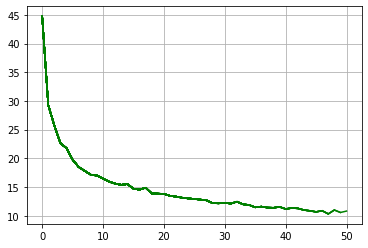

In [ ]:
tf.reset_default_graph()
train()

In [ ]:
tf.reset_default_graph()
test()

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/MP/Sequence 2 Vector/models/glove+blstm/model-500


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0 /content/drive/My Drive/MP/test/8mSUD7JGNO0_174_181.npy
a man is riding a horse 

1 /content/drive/My Drive/MP/test/ljGcQocjSs4_38_60.npy
a man is shooting with a gun 

2 /content/drive/My Drive/MP/test/E2r6nnkwl0c_6_18.npy
a man is taking a huge out of a flip 

3 /content/drive/My Drive/MP/test/-_hbPLsZvvo_323_328.npy
a woman is slicing a cucumber 

4 /content/drive/My Drive/MP/test/MTkGPfMRXtc_5_21.npy
a woman is reading a piece of paper 

5 /content/drive/My Drive/MP/test/aeA-HN7BMdo_34_41.npy
a person is cutting broccoli 

6 /content/drive/My Drive/MP/test/kquB3rIgfGk_640_645.npy
a man is putting a lid of a box of spaghetti into a glass 

7 /content/drive/My Drive/MP/test/a1Y73sPHKxw_0_5.npy
a rabbit is eating 

8 /content/drive/My Drive/MP/test/bQJQGoJF7_k_109_115.npy
a man is putting some in a container 

9 /content/drive/My Drive/MP/test/PHDmVhShE80_20_29.npy
a woman is slicing a fresh food 

10 /content/drive/My Drive/MP/test/xxHx6s_DbUo_41_44.npy
11 /content/drive/My Drive/M

In [ ]:
tf.nn.embedding_lookup(Wemb,[0,1,2])

<tf.Tensor 'embedding_lookup/Identity:0' shape=(3, 104) dtype=float64>